In [13]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import random, os
import seaborn as sns
from glob import glob 
from PIL import Image
import cv2
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, History
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix, classification_report

In [14]:
#Import metadata 
df =pd.read_csv('HAM10000_metadata.csv')

## Simple EDA

In [15]:
df.head(25)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


Text(0.5, 1.0, 'Frequency Distribution of Classes')

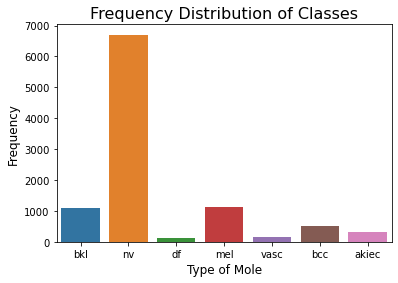

In [16]:
##Frequency distribution of classes:
sns.countplot(x = 'dx', data = df)
plt.xlabel('Type of Mole', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

In [17]:
path = "HAM10000_images/"

In [18]:
df.shape

(10015, 7)

In [19]:
#Check for duplicates in dataset and remove them

bool_series = df['lesion_id'].duplicated()
bool_series.sum()

2545

In [20]:
#Removing duplicated 
df.drop_duplicates(subset ="lesion_id",
                     keep = "first", inplace = True)

In [21]:
df.shape

(7470, 7)

Text(0.5, 1.0, 'Frequency Distribution of Classes')

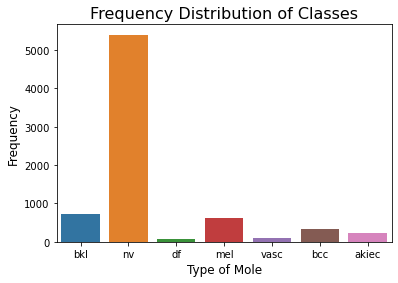

In [22]:
##Frequency distribution of classes after dropping duplicates:
sns.countplot(x = 'dx', data = df)
plt.xlabel('Type of Mole', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

In [26]:
#Adding name of image to dataset
df["image_name"] = df['image_id']+ '.jpg'
X = df[["image_name",'dx', 'lesion_id']]
y = X.pop('dx').to_frame()

In [27]:
X.sample(5)

,image_name,lesion_id
8815,ISIC_0024363.jpg,HAM_0004534
4876,ISIC_0029175.jpg,HAM_0002806
5434,ISIC_0031066.jpg,HAM_0006488
2739,ISIC_0024454.jpg,HAM_0005180
2995,ISIC_0026425.jpg,HAM_0002971


In [28]:
y.value_counts()

dx   
nv       5403
bkl       727
mel       614
bcc       327
akiec     228
vasc       98
df         73
dtype: int64

### Oversampling for imbalanced dataset

In [29]:
#TODO try to achieve a balanced dataset here!!
#undersample = RandomUnderSampler(sampling_strategy='majority')
sampling_strategy = {'bkl': 600, 'nv':2000 , 'df': 73, 'mel':500 , 'vasc':98 , 'bcc':327 , 'akiec':228 }
#undersample = RandomUnderSampler(sampling_strategy='majority')
#undersample = RandomUnderSampler(sampling_strategy= sampling_strategy)
oversample = RandomOverSampler(sampling_strategy='minority')
X,y  = oversample.fit_resample(X,y)
#X,y = undersample.fit_resample(X,y)

In [30]:
X.shape

(12800, 2)

In [31]:
X.value_counts()

image_name        lesion_id  
ISIC_0030244.jpg  HAM_0007526    92
ISIC_0033808.jpg  HAM_0003081    90
ISIC_0029297.jpg  HAM_0002153    89
ISIC_0027598.jpg  HAM_0002848    89
ISIC_0032642.jpg  HAM_0002909    89
                                 ..
ISIC_0027402.jpg  HAM_0006556     1
ISIC_0027401.jpg  HAM_0007046     1
ISIC_0027400.jpg  HAM_0002062     1
ISIC_0027399.jpg  HAM_0000935     1
ISIC_0034320.jpg  HAM_0002244     1
Length: 7470, dtype: int64

In [32]:
y.shape

(12800, 1)

In [33]:
y.value_counts()

dx   
df       5403
nv       5403
bkl       727
mel       614
bcc       327
akiec     228
vasc       98
dtype: int64

Text(0.5, 1.0, 'Frequency Distribution of Classes')

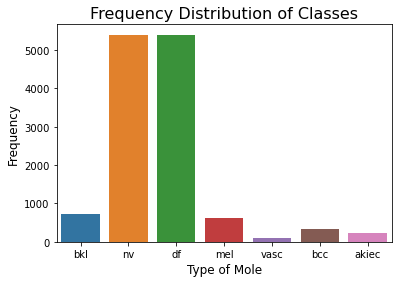

In [34]:
sns.countplot(x = 'dx', data = y)
plt.xlabel('Type of Mole', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

### Splitting the dataset

In [35]:
#Splitting dataset
#Reference https://www.youtube.com/watch?v=nuakBf3rBmw, https://www.kaggle.com/code/dhruv1234/ham10000-skin-disease-classification/notebook

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, random_state=42)

In [36]:
#create aparts datasets after splitting
train = pd.concat([X_train, y_train], axis = 1)
val = pd.concat([X_val, y_val], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

In [37]:
encoder = LabelEncoder()
encoder.fit(test['dx'])
name_as_indexes_test = encoder.transform(test['dx'])
test['label'] = name_as_indexes_test

In [38]:
encoder = LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_test = encoder.transform(val['dx'])
val['label'] = name_as_indexes_test

In [39]:
test.head()

,image_name,lesion_id,dx,label
5173,ISIC_0028300.jpg,HAM_0004092,nv,5
9590,ISIC_0026629.jpg,HAM_0004065,df,3
1355,ISIC_0027560.jpg,HAM_0003885,mel,4
6114,ISIC_0034069.jpg,HAM_0003441,nv,5
3519,ISIC_0024719.jpg,HAM_0007154,nv,5


In [40]:
val.head()

,image_name,lesion_id,dx,label
5446,ISIC_0026061.jpg,HAM_0001973,nv,5
12747,ISIC_0030321.jpg,HAM_0003555,df,3
3892,ISIC_0029586.jpg,HAM_0003864,nv,5
7908,ISIC_0026254.jpg,HAM_0006816,df,3
6278,ISIC_0032021.jpg,HAM_0000335,nv,5


In [41]:
train.shape

(8192, 3)

In [42]:
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range = 10, 
                                     zoom_range = 0.1,
                                     width_shift_range=0.0, height_shift_range=0.00
)

In [43]:
#train_data = train_generator.flow_from_dataframe(dataframe=train, x_col='image_name', y_col="dx", batch_size=32, directory=path, shuffle =True, class_mode="categorical", target_size=(224,224), subset="training")
train_data = train_generator.flow_from_dataframe(dataframe=train, x_col='image_name', y_col="dx", batch_size=64, directory=path, shuffle =True, class_mode="categorical", target_size=(224,224), subset="training")

Found 8192 validated image filenames belonging to 7 classes.


In [44]:
for t in train_data: 
    print(t)
    break

(array([[[[0.8771697 , 0.49677756, 0.66540504],
         [0.88528395, 0.50489175, 0.6735192 ],
         [0.88379204, 0.5050009 , 0.6656233 ],
         ...,
         [0.86705625, 0.55364245, 0.65975857],
         [0.8702957 , 0.5594733 , 0.66753304],
         [0.87353504, 0.56530416, 0.6753075 ]],

        [[0.8758293 , 0.4954371 , 0.6640646 ],
         [0.8839435 , 0.5035513 , 0.6721788 ],
         [0.886473  , 0.5070116 , 0.67098516],
         ...,
         [0.887335  , 0.5892958 , 0.7055289 ],
         [0.88927865, 0.5912394 , 0.7048811 ],
         [0.89122224, 0.593183  , 0.70423317]],

        [[0.8745099 , 0.49410716, 0.6627135 ],
         [0.882603  , 0.5022108 , 0.6708383 ],
         [0.8891539 , 0.5090223 , 0.6763471 ],
         ...,
         [0.90118444, 0.6044033 , 0.7069931 ],
         [0.90442383, 0.6089384 , 0.71217614],
         [0.9076632 , 0.61347353, 0.7173591 ]],

        ...,

        [[0.811315  , 0.5021107 , 0.5880854 ],
         [0.8093714 , 0.50275856, 0.58743757

In [45]:
print('Type of classes:' ,train_data.class_indices)
print('Number of samples: ',train_data.samples)
print('Number of class: ',len(train_data.class_indices))
print('Number of samples per class: ', int(train_data.samples/len(train_data.class_indices)))

Type of classes: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Number of samples:  8192
Number of class:  7
Number of samples per class:  1170


In [46]:
train_data.image_shape

(224, 224, 3)

In [47]:
test_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range = 10, 
                                     zoom_range = 0.1,
                                     width_shift_range=0.0, height_shift_range=0.02
)


In [48]:
test_data = test_generator.flow_from_dataframe(dataframe=test, x_col='image_name', y_col="dx", batch_size=64, directory=path, shuffle=False, class_mode="categorical", target_size=(224,224))

Found 2560 validated image filenames belonging to 7 classes.


In [49]:
test_data.image_shape

(224, 224, 3)

In [50]:
test_data

In [51]:
print('Type of classes:' ,test_data.class_indices)
print('Number of samples: ',test_data.samples)
print('Number of class: ',len(test_data.class_indices))
print('Number of samples per class: ', int(test_data.samples/len(test_data.class_indices)))

Type of classes: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Number of samples:  2560
Number of class:  7
Number of samples per class:  365


In [52]:
val_data = test_generator.flow_from_dataframe(dataframe=val, x_col='image_name', y_col="dx", batch_size=64, directory=path, shuffle=True, class_mode="categorical", target_size=(224,224))

Found 2048 validated image filenames belonging to 7 classes.


In [53]:
val_data.image_shape

(224, 224, 3)

In [54]:
print('Type of classes:' ,val_data.class_indices)
print('Number of samples: ',val_data.samples)
print('Number of class: ',len(val_data.class_indices))
print('Number of samples per class: ', int(val_data.samples/len(val_data.class_indices)))

Type of classes: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Number of samples:  2048
Number of class:  7
Number of samples per class:  292


### Showcase some of the training images

In [55]:
def plot_images(img_array):
    fig, axes = plt.subplots(1,5, figsize=(25,25))
    axes = axes.flatten()
    for img, ax in zip(img_array,axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

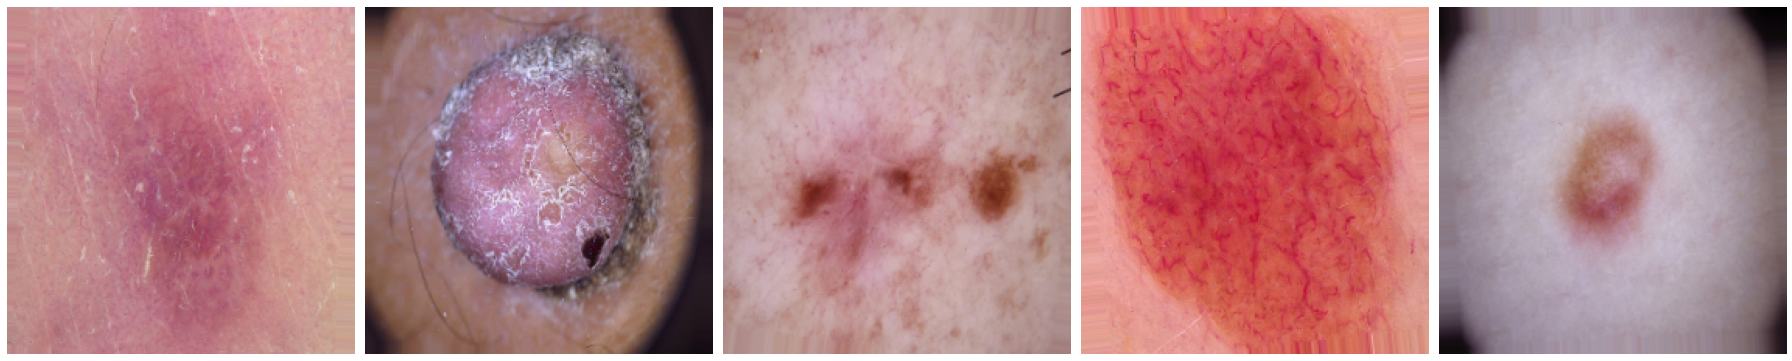

In [56]:
sample_train_images, _ = next(train_data)
plot_images(sample_train_images[:5])

In [57]:
#Using model
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))


In [58]:
model = Sequential()
model.add(base_model)
model.add(Conv2D(16,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.40))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
#Output layer must match the different outputs from our labels, in this case 7
model.add(Dense(7,activation='sigmoid'))

In [59]:
#Reference https://www.kaggle.com/code/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe/notebook
# We'll stop training if no improvement after some epochs
earlystopper = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
# Save the best model during the traning
checkpointer = ModelCheckpoint('./model/best_model1.h5'
                                        ,monitor='val_accuracy'
                                        ,verbose=1
                                        ,save_best_only=True
                                        ,save_weights_only=True)
history1 = History()

In [60]:
#learning_control = ReduceLROnPlateau(monitor='val_acc',patience=3, verbose=1, factor=.5, min_lr=0.0001)

In [61]:
#Defining metrics
# METRICS = [
#       metrics.TruePositives(name='tp'),
#       metrics.FalsePositives(name='fp'),
#       metrics.TrueNegatives(name='tn'),
#       metrics.FalseNegatives(name='fn'), 
#       metrics.CategoricalAccuracy(name='accuracy'),
#       metrics.CategoricalAccuracy(name='val_acc'),
#       metrics.Precision(name='precision'),
#       metrics.Recall(name='recall'),
#       metrics.AUC(name='auc'),
#       metrics.AUC(name='prc', curve='PR'), # precision-recall curve
# ]

In [62]:
sgd = SGD(learning_rate=0.01,clipvalue=0.5)
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=['accuracy'])

In [63]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 16)          184336    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 16)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2, 2, 16)          0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)              

In [64]:
history=model.fit(train_data,batch_size=128, epochs=15, validation_data=val_data ,callbacks=[earlystopper, checkpointer, reduce_lr, history1])


Epoch 1/15
128/128 [==============================] - ETA: 0s - loss: 0.9792 - accuracy: 0.6902
Epoch 1: val_accuracy improved from -inf to 0.39355, saving model to ./model\best_model1.h5
128/128 [==============================] - 923s 7s/step - loss: 0.9792 - accuracy: 0.6902 - val_loss: 1.5941 - val_accuracy: 0.3936 - lr: 0.0100
Epoch 2/15
128/128 [==============================] - ETA: 0s - loss: 0.5126 - accuracy: 0.8271
Epoch 2: val_accuracy improved from 0.39355 to 0.40234, saving model to ./model\best_model1.h5
128/128 [==============================] - 855s 7s/step - loss: 0.5126 - accuracy: 0.8271 - val_loss: 1.9027 - val_accuracy: 0.4023 - lr: 0.0100
Epoch 3/15
128/128 [==============================] - ETA: 0s - loss: 0.4471 - accuracy: 0.8370  
Epoch 3: val_accuracy improved from 0.40234 to 0.40576, saving model to ./model\best_model1.h5
128/128 [==============================] - 11177s 88s/step - loss: 0.4471 - accuracy: 0.8370 - val_loss: 1.7745 - val_accuracy: 0.4058 - l

In [65]:
#Get the best saved weights
model.load_weights('./model/best_model1.h5')

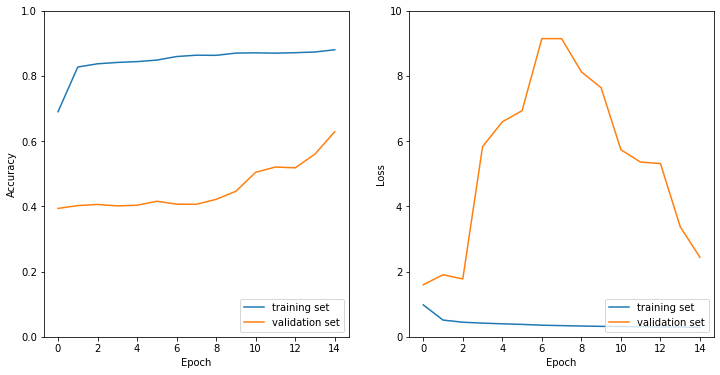

In [66]:
import tensorflow

def plot_history(history):
    """ This helper function takes the tensorflow.python.keras.callbacks.History
    that is output from your `fit` method to plot the loss and accuracy of
    the training and validation set.
    """
    
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    #plt.title("Model Accuracy")
    #axs[0].plt.title('Model Accuracy')
    axs[0].plot(history.history['accuracy'], label='training set')
    axs[0].plot(history.history['val_accuracy'], label = 'validation set')
    axs[0].set(xlabel = 'Epoch', ylabel='Accuracy', ylim=[0, 1])
    
    #plt.title("Model Loss")
    axs[1].plot(history.history['loss'], label='training set')
    axs[1].plot(history.history['val_loss'], label = 'validation set')
    axs[1].set(xlabel = 'Epoch', ylabel='Loss', ylim=[0, 10])
    
    axs[0].legend(loc='lower right')
    axs[1].legend(loc='lower right')
    
plot_history(history)

In [67]:
loss, acc = model.evaluate(test_data, verbose=0)
model.evaluate(test_data, verbose=2)

print('Test loss:', loss)
print('Test accuracy:', acc)

40/40 - 95s - loss: 2.5456 - accuracy: 0.6242 - 95s/epoch - 2s/step
Test loss: 2.4960923194885254
Test accuracy: 0.621874988079071


In [68]:
loss, acc = model.evaluate(val_data, verbose=2)
print('Validation loss:', loss)
print('Validation accuracy:', acc)

32/32 - 65s - loss: 2.4440 - accuracy: 0.6147 - 65s/epoch - 2s/step
Validation loss: 2.443960428237915
Validation accuracy: 0.61474609375


In [69]:
history.history

{'loss': [0.9792371392250061,
  0.5125731825828552,
  0.44705909490585327,
  0.41910451650619507,
  0.3985023498535156,
  0.3800886869430542,
  0.35581210255622864,
  0.34272000193595886,
  0.33102282881736755,
  0.3203281760215759,
  0.3157895505428314,
  0.308659166097641,
  0.302400141954422,
  0.29949501156806946,
  0.2890409529209137],
 'accuracy': [0.690185546875,
  0.8271484375,
  0.8370361328125,
  0.8411865234375,
  0.84375,
  0.848388671875,
  0.8592529296875,
  0.8634033203125,
  0.8629150390625,
  0.869873046875,
  0.87060546875,
  0.86962890625,
  0.87109375,
  0.8731689453125,
  0.8800048828125],
 'val_loss': [1.5941377878189087,
  1.902669906616211,
  1.774502158164978,
  5.8292388916015625,
  6.591302871704102,
  6.933313846588135,
  9.141794204711914,
  9.141388893127441,
  8.12441635131836,
  7.63513708114624,
  5.734645366668701,
  5.355299472808838,
  5.313323020935059,
  3.3771445751190186,
  2.434565544128418],
 'val_accuracy': [0.3935546875,
  0.40234375,
  0.405

In [72]:
print('Loss is ' + str(history.history['loss'][14]))

Loss is 0.2890409529209137


In [73]:
print('Accuracy is ' + str(history.history['accuracy'][14]))

Accuracy is 0.8800048828125


In [300]:
#print('Precision is ' + str(history.history['precision'][4]))

In [383]:
#print('Recall is ' + str(history.history['recall'][4]))

In [74]:
model.save('./model/my_model.h5')

In [75]:
# Dictionary with different classes of moles:
#Reference: https://www.kaggle.com/code/dhruv1234/ham10000-skin-disease-classification/notebook
classes = {4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'), 2 :('bkl', 'benign keratosis-like lesions'), 1:('bcc' , ' basal cell carcinoma'), 5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  3: ('df', 'dermatofibroma')}

### Predicting Class Type

ISIC_0028351.jpg


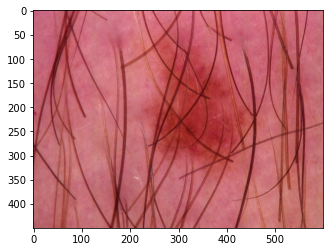

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0032553.jpg


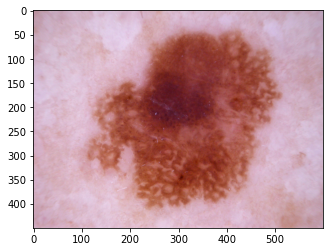

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0027802.jpg


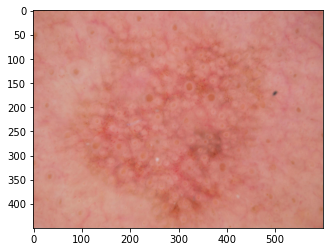

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0027457.jpg


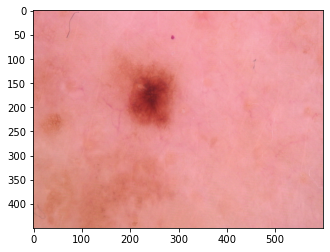

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0031831.jpg


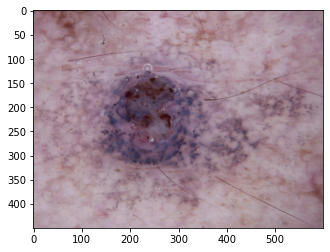

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0024632.jpg


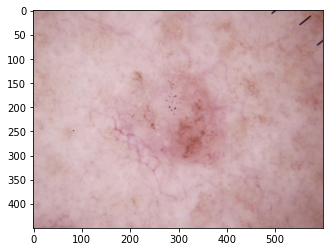

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0031545.jpg


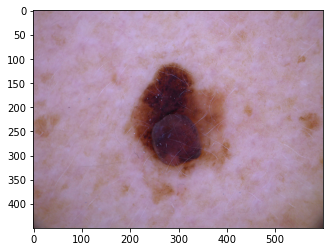

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0025254.jpg


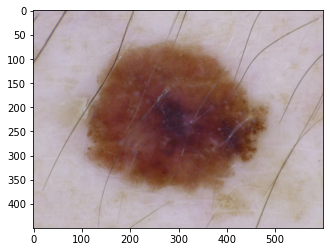

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0026042.jpg


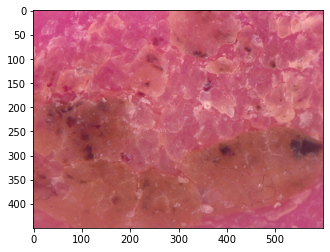

('vasc', ' pyogenic granulomas and hemorrhage')
ISIC_0031517.jpg


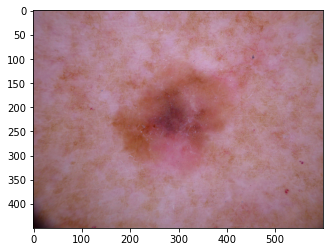

('vasc', ' pyogenic granulomas and hemorrhage')


In [90]:

for temp in range(0,10):
    img_name = random.choice(os.listdir(path))
    print(img_name)
    img = cv2.imread(os.path.join(path, img_name))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    img = cv2.resize(img, (224, 224))
    result = model.predict(img.reshape(1, 224, 224, 3))
    max_prob = max(result[0])
    class_ind = list(result[0]).index(max_prob)
    class_name = classes[class_ind]
    print(class_name)
    

In [ ]:
#Classification Report

#print(classification_report(classes, preds_cls.astype(int)))